# Setup

In [1]:
# Python >=3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn >=0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow >=2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >="2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", 
             resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

A couple utility functions to plot grayscale and RGB images:

In [2]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")
    
def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

# What is a Convolution?

<img src="https://github.com/soo-pecialist/Hands_on_ML_w_Scikit_Karas_and_TensorFlow/blob/master/images_used/figure14_3.png?raw=true" alt="Figure 14-3" width=500>

<img src="https://github.com/soo-pecialist/Hands_on_ML_w_Scikit_Karas_and_TensorFlow/blob/master/images_used/figure14_4.png?raw=true" alt="Figure 14-4" width=500>

<img src="https://github.com/soo-pecialist/Hands_on_ML_w_Scikit_Karas_and_TensorFlow/blob/master/images_used/figure14_5.png?raw=true" alt="Figure 14-5" width=500>



In TensorFlow, each input image is typically represented as a 3D tensor of shape `[height, width, channels]`. A mini-batch is represented as a 4D tensor of shape `[mini-batch size, height, width, channels]`. The weights of a convolutional layer are represented as a 4D tensor of shape `[fh, fw, fn, fn]`. The bias terms of a convolutional layer are simply represented as a 1D tensor of shape `[fn]`.

<img src="https://github.com/soo-pecialist/Hands_on_ML_w_Scikit_Karas_and_TensorFlow/blob/master/images_used/figure14_7.png?raw=true" alt="Figure 14-7" width=500>

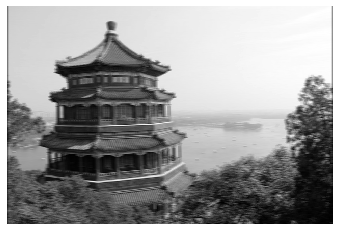

In [3]:
import numpy as np
from sklearn.datasets import load_sample_image

# Load sample images
china = load_sample_image("china.jpg") / 255 # (427, 640, 3)
flower = load_sample_image("flower.jpg") /255 # (427, 640, 3)
images = np.array([china, flower]) # (2, 427, 640, 3)
batch_size, height, width, channels = images.shape

# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

plt.imshow(outputs[0, :, :, 1], cmap="gray") # plot 1st image's 2nd feature map
plt.axis("off")
plt.show()

In [4]:
china.shape, flower.shape, images.shape

((427, 640, 3), (427, 640, 3), (2, 427, 640, 3))

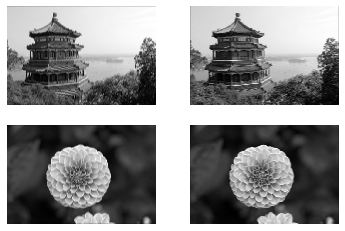

In [5]:
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(outputs[image_index, :, :, feature_map_index])

plt.show()

In [6]:
def crop(images):
    return images[150:220, 130:250]

Saving figure china_original


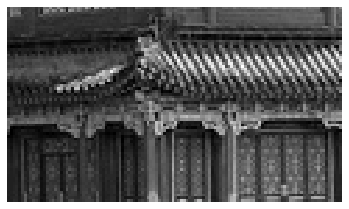

Saving figure china_vertical


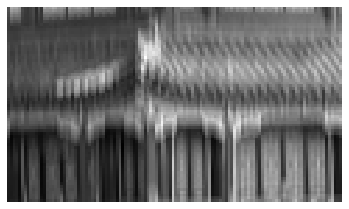

Saving figure china_horizontal


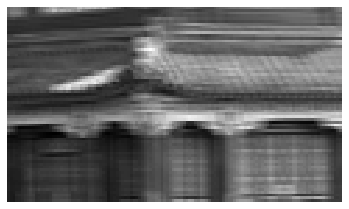

In [7]:
plot_image(crop(images[0, :, :, 0]))
save_fig("china_original", tight_layout=False)
plt.show()

for feature_map_index, filename in enumerate(["china_vertical", "china_horizontal"]):
    plot_image(crop(outputs[0, :, :, feature_map_index]))
    save_fig(filename, tight_layout=False)
    plt.show()

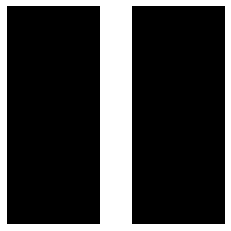

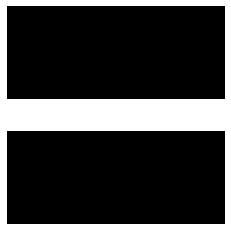

In [8]:
plot_image(filters[:, :, 0, 0])
plt.show()
plot_image(filters[:, :, 0, 1])
plt.show();

## Convolutional Layer
Using `keras.layers.Conv2D()`:

In [9]:
conv = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, 
                           padding="SAME", activation="relu")

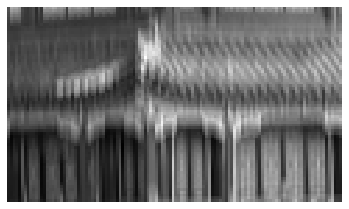

In [10]:
plot_image(crop(outputs[0, :, :, 0]))
plt.show()

## VALID vs SAME padding

In [11]:
def feature_map_size(input_size, kernal_size, strides=1, padding="SAME"):
    # 1-D size calculation
        if padding == "SAME":
                return (input_size -1) // strides +1
        else: 
            return (input_size - kernel_size) // strides + 1

In [12]:
def pad_before_and_padded_size(input_size, kernel_size, strides=1):
    fmap_size = feature_map_size(input_size, kernel_size, strides)
    padded_size = max((fmap_size -1) * strides + kernel_size, input_size)
    pad_before = (padded_size - input_size) // 2
    return pad_before, padded_size

In [13]:
def manual_same_padding(images, kernel_size, strides=1):
    if kernel_size == 1:
        return images.astype(np.float32)
    batch_size, height, width, channels = images.shape
    top_pad, padded_height = pad_before_and_padded_size(height, kernel_size, strides)
    left_pad, padded_width = pad_before_and_padded_size(width, kernel_size, strides)
    padded_shape = [batch_size, padded_height, padded_width, channels]
    padded_images = np.zeros(padded_shape, dtype=np.float32)
    padded_images[:, top_pad:height+top_pad, left_pad:width+left_pad, :] = images
    return padded_images

Using `"SAME"` padding is equivalent to padding manually using `manual_same_padding()` then using `"VALID"` padding (confusingly, `"VALID"` padding means no padding at all):

In [14]:
kernel_size = 7
strides = 2

conv_valid = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, 
                                 strides=strides, padding="valid".upper())
conv_same = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, 
                                strides=strides, padding="same".upper())

valid_output = conv_valid(manual_same_padding(images, kernel_size, strides))

# Neet to call build() so conv_same's weight get created
conv_same.build(tf.TensorShape(images.shape))

# Copy the weights from conv_valid to conv_same
conv_same.set_weights(conv_valid.get_weights())

same_output = conv_same(images.astype(np.float32))

assert np.allclose(valid_output.numpy(), same_output.numpy())

# Pooling layer

## Max pooling

Other than reducing computations, memory usage and the number of parameters, a max pooling layer also introduces some level of invariance to small translations. By inserting a max pooling layer every few layers in a CNN, it is possible to get some level of translation invariance at a larger scale. Moreover, max pooling also offers a small amount of rotational invariance and a slight scale invariance. Such invariance (even if it is limited) can be useful in cases where the prediction should not depend on these details, such as in classification tasks.

<img src="https://github.com/soo-pecialist/Hands_on_ML_w_Scikit_Karas_and_TensorFlow/blob/master/images_used/figure14_8.png?raw=true" alt="Figure 14-7" width=500>

In [15]:
max_pool = keras.layers.MaxPool2D(pool_size=2)

In [16]:
cropped_images = np.array([crop(image.astype(np.float32)) for image in images])
output = max_pool(cropped_images)

Saving figure china_max_pooling


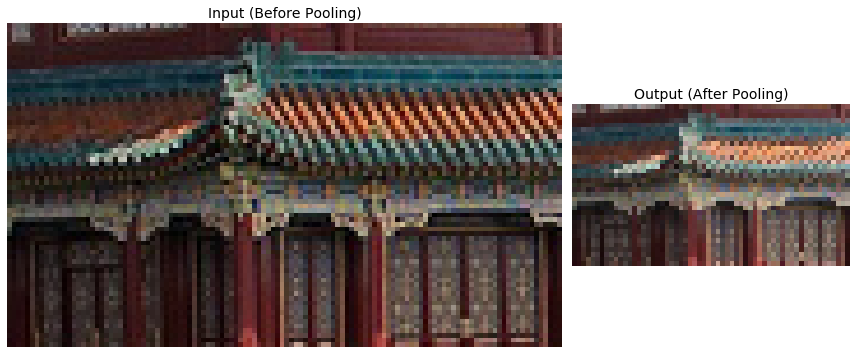

In [17]:
fig = plt.figure(figsize=(12,8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2,1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input (Before Pooling)", fontsize=14)
ax1.imshow(cropped_images[0]) # plot the 1st image // before max pooling
ax1.axis("off")

ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output (After Pooling)", fontsize=14)
ax2.imshow(output[0]) # plot the output for the 1st image
ax2.axis("off")

save_fig("china_max_pooling")
plt.show()


## Average pooling

Average pooling layers used to be very popular, but people mostly use max pooling layers now, as they generally perform better. 

In [18]:
avg_pool = keras.layers.AvgPool2D(pool_size=2)

In [19]:
output_avg = avg_pool(cropped_images)
output_avg.shape

TensorShape([2, 35, 60, 3])

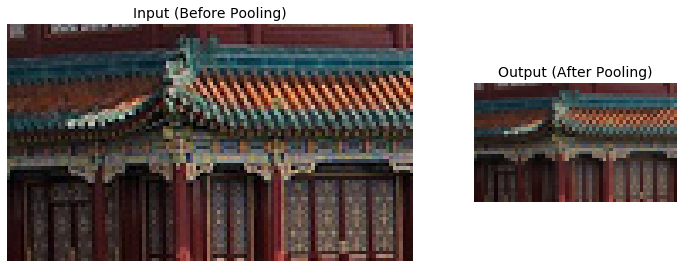

In [20]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input (Before Pooling)", fontsize=14) # plot the 1st image
ax1.imshow(cropped_images[0])
ax1.axis("off")

ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output (After Pooling)", fontsize=14) # Plot the output for the 1st image
ax2.imshow(output_avg[0])
ax2.axis("off")
plt.show();


## Global Average Pooling

In [21]:
cropped_images.shape

(2, 70, 120, 3)

In [22]:
global_avg_pool = keras.layers.GlobalAveragePooling2D()
global_avg_pool(cropped_images)

<tf.Tensor: id=122, shape=(2, 3), dtype=float32, numpy=
array([[0.2788801 , 0.22507527, 0.20967631],
       [0.51287866, 0.4595188 , 0.3342377 ]], dtype=float32)>

In [23]:
output_global_avg2 = keras.layers.Lambda(lambda X: tf.reduce_mean(X, axis=[1, 2]))
output_global_avg2(cropped_images)

<tf.Tensor: id=125, shape=(2, 3), dtype=float32, numpy=
array([[0.2788801 , 0.22507527, 0.20967631],
       [0.51287866, 0.4595188 , 0.3342377 ]], dtype=float32)>

## Depth-wise pooling

Note that max pooling and average pooling can be performed along the depth dimen‐ sion rather than the spatial dimensions, although this is not as common. This can allow the CNN to learn to be invariant to various features. For example, it could learn multiple filters, each detecting a different rotation of the same pattern, such as hand- written digits, and the depth-wise max pooling layer would ensure that the output is the same regardless of the rotation. The CNN could similarly learn to be invariant to anything else: thickness, brightness, skew, color, and so on. 

<img src="https://github.com/soo-pecialist/Hands_on_ML_w_Scikit_Karas_and_TensorFlow/blob/master/images_used/figure14_10.png?raw=true" alt="Figure 14-7" width=500>

Keras does **not** include a depth-wise max pooling layer, but `TensorFlow`’s low-level Deep Learning API does: just use the `tf.nn.max_pool()` function, and **specify the kernel size and strides as 4-tuples**.

In [24]:
class DepthMaxPool(keras.layers.Layer):
    def __init__(self, pool_size=None, strides=None, padding="VALID", **kwargs):
        super().__init__(**kwargs)
        if pool_size is None:
            print("Do not forget to provide binary ndarray")
        if strides is None:
            strides = pool_size     

        self.pool_size = pool_size # reference that basically pool_size = depth
        self.strides = strides
        self.padding = padding  
        
    def call(self, inputs):
        try:
            if not self.pool_size:
                self.pool_size = inputs.shape[-1]
        except Exception as e:
            print(e)
        
        self.strides = self.pool_size
        
        return tf.nn.max_pool(inputs, 
                             ksize=(1, 1, 1, self.pool_size), 
                             strides=(1, 1, 1, self.pool_size),
                             padding=self.padding)

In [25]:
depth_pool = DepthMaxPool(3) #RGB channels
with tf.device("/cpu:0"): # there is no GPU-kernel yet
    depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 70, 120, 1])

Or just use a `Lambda` layer:

In [26]:
depth_pool = keras.layers.Lambda(
                    lambda X: tf.nn.max_pool(X,
                                             ksize=(1, 1, 1, 3),
                                             strides=(1, 1, 1, 3),
                                             padding="VALID"))

with tf.device("/cpu:0"): # there is no GPU-kernel yet
    depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 70, 120, 1])

In [27]:
np.squeeze(depth_output[0], axis=-1).shape

(70, 120)

In [28]:
cropped_images[0].shape

(70, 120, 3)

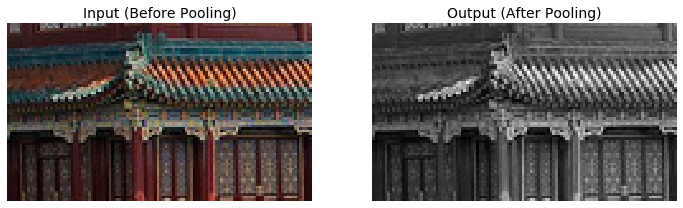

In [29]:
plt.figure(figsize=(12, 8))
plt.subplot(1,2,1)
plt.title("Input (Before Pooling)", fontsize=14)
plot_color_image(cropped_images[0]) # plot the 1st image

plt.subplot(1,2,2)
plt.title("Output (After Pooling)", fontsize=14)
plot_image(depth_output[0, ..., 0]) ## depth_output[0, ..., 0]  
                                    ## = np.squeeze(depth_output[0], axis=-1).shape

# Tackling Fashion MNIST With a CNN

Below is a typical CNN architecture:
<img src="https://github.com/soo-pecialist/Hands_on_ML_w_Scikit_Karas_and_TensorFlow/blob/master/images_used/figure14_11.png?raw=true" alt="Figure 14-7" width=600>

> A common mistake is to use convolution kernels that are too large. For example, instead of using a convolutional layer with a 5 × 5 kernel, it is generally preferable to stack two layers with 3 × 3 kernels: it will use less parameters and require less computations, and it will usually perform better. One exception to this recommendation is for the first convolutional layer: it can typically have a large kernel (e.g., 5 × 5), usually with stride of 2 or more: this will reduce the spatial dimension of the image without losing too much infor‐ mation, and since the input image only has 3 channels in general, it will not be too costly.

In [30]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
                                                 # ndarrays
X_train_full.shape, y_train_full.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [31]:
def standardization(X, keepdims=True):
    X_mean = X.mean(axis=0, keepdims=keepdims)
    X_std = X.std(axis=0, keepdims=keepdims) + 1e-7
    X_scaled = (X - X_mean) / X_std
    X_scaled = X_scaled[..., np.newaxis]
    
    return X_scaled

In [32]:
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_train = standardization(X_train)
X_valid = standardization(X_valid)
X_test = standardization(X_test)

# X_train.shape # (55000, 28, 28, 1)

In [33]:
from functools import partial

# simply avoids having to repeat the same hyperparameter values over and over again.
DefaultConv2D = partial(keras.layers.Conv2D,
                       kernel_size=3, activation='relu', padding='SAME')

model = keras.models.Sequential([
        DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
        keras.layers.MaxPooling2D(pool_size=2),
        DefaultConv2D(filters=128),
        DefaultConv2D(filters=128),
        keras.layers.MaxPooling2D(pool_size=2),
        DefaultConv2D(filters=256),
        DefaultConv2D(filters=256),
        keras.layers.MaxPooling2D(pool_size=2),
        keras.layers.Flatten(),
        keras.layers.Dense(units=128, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(units=128, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(units=10, activation='softmax')
])

In [34]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=15, validation_data=[X_valid, y_valid])
score = model.evaluate(X_test, y_test, verbose=0)

X_new = X_test[:10] # pretend we have new images
y_pred = model.predict(X_new)

score

Train on 55000 samples, validate on 5000 samples
Epoch 1/15
55000/55000 [==============================] - 171s 3ms/sample - loss: 0.6303 - accuracy: 0.7798 - val_loss: 0.3520 - val_accuracy: 0.8734
Epoch 2/15
55000/55000 [==============================] - 249s 5ms/sample - loss: 0.3835 - accuracy: 0.8689 - val_loss: 0.3094 - val_accuracy: 0.8834
Epoch 3/15
55000/55000 [==============================] - 224s 4ms/sample - loss: 0.3366 - accuracy: 0.8838 - val_loss: 0.2962 - val_accuracy: 0.8984
Epoch 4/15
55000/55000 [==============================] - 214s 4ms/sample - loss: 0.3023 - accuracy: 0.8960 - val_loss: 0.2846 - val_accuracy: 0.8926
Epoch 5/15
55000/55000 [==============================] - 212s 4ms/sample - loss: 0.2844 - accuracy: 0.9035 - val_loss: 0.2728 - val_accuracy: 0.8992
Epoch 6/15
55000/55000 [==============================] - 183s 3ms/sample - loss: 0.2672 - accuracy: 0.9072 - val_loss: 0.2630 - val_accuracy: 0.9018
Epoch 7/15
55000/55000 [===========================

[0.3071706637978554, 0.9067]

Saving figure keras_learning_curves_plot


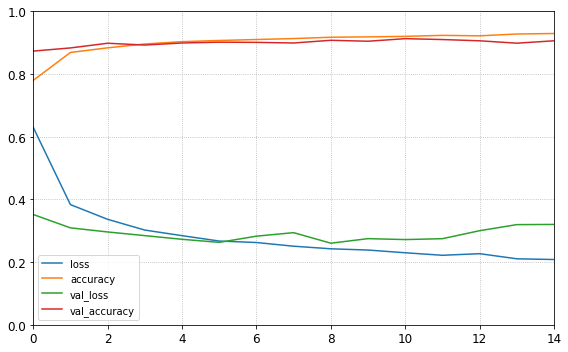

In [35]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.grid(linestyle=':')
save_fig("keras_learning_curves_plot")
plt.show()

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 64)        3200      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 128)       147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 256)         295168    
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 7, 7, 256)         5

## ResNet-34

In [41]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1, 
                       padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation='relu', **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters), 
            keras.layers.BatchNormalization()
        ]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()
            ]
    
    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [44]:
model = keras.models.Sequential(name="ResNet-34")
model.add(DefaultConv2D(64, kernel_size=7, strides=2,
                       input_shape=(224, 224, 3)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))

prev_filters=64
for filters in [64]*3 + [128]*4 + [256]*6 + [512]*3:
    strides=1 if filters==prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

In [45]:
model.summary()

Model: "ResNet-34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_45 (Conv2D)           (None, 112, 112, 64)      9408      
_________________________________________________________________
batch_normalization_37 (Batc (None, 112, 112, 64)      256       
_________________________________________________________________
activation_2 (Activation)    (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
residual_unit_17 (ResidualUn (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_18 (ResidualUn (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_19 (ResidualUn (None, 56, 56, 64)        74

## Using a Pretrained Model

In [46]:
model = keras.applications.resnet50.ResNet50(weights="imagenet")

102973440/102967424 [==============================] - 7s 0us/step


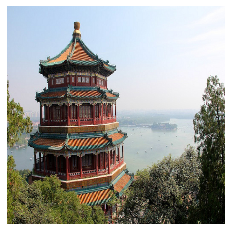

In [47]:
images_resized = tf.image.resize(images, [224, 224])
plot_color_image(images_resized[0])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


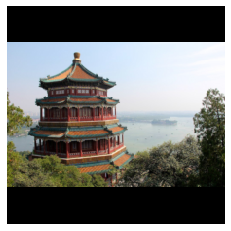

In [48]:
images_resized = tf.image.resize_with_pad(images, 224, 224, antialias=True)
plot_color_image(images_resized[0])

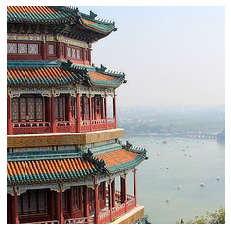

In [49]:
images_resized = tf.image.resize_with_crop_or_pad(images, 224, 224)
plot_color_image(images_resized[0])
plt.show()

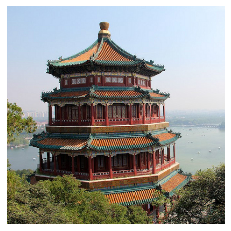

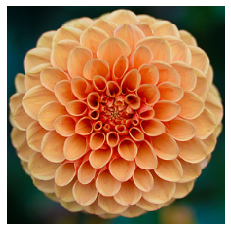

In [50]:
china_box = [0, 0.03, 1, 0.68]
flower_box = [0.19, 0.26, 0.86, 0.7]
images_resized = tf.image.crop_and_resize(images, [china_box, flower_box], [0, 1], [224, 224])
plot_color_image(images_resized[0])
plt.show()
plot_color_image(images_resized[1])
plt.show()

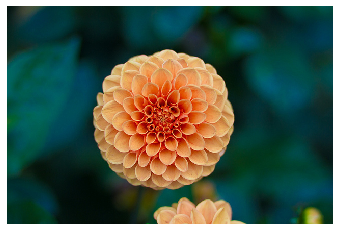

In [51]:
plot_color_image(images[1])

In [52]:
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)
Y_proba = model.predict(inputs)

In [53]:
Y_proba.shape

(2, 1000)

In [55]:
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print(f"Image #{image_index}")
    for class_id, name, y_proba in top_K[image_index]:
        print(f"  {class_id} - {name:12s} {y_proba * 100:.2f}%")
    print()

Image #0
  n03877845 - palace       43.39%
  n02825657 - bell_cote    43.07%
  n03781244 - monastery    11.70%

Image #1
  n04522168 - vase         53.96%
  n07930864 - cup          9.52%
  n11939491 - daisy        4.97%



## Pretrained Models for Transfer Learning
If you want to build an image classifier, but you do not have enough training data, then it is often a good idea to reuse the lower layers of a pretrained model.

In [56]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset tf_flowers downloaded and prepared to /Users/soohyeonkim/tensorflow_datasets/tf_flowers/1.0.0. Subsequent calls will reuse this data.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [57]:
info.splits

{'train': <tfds.core.SplitInfo num_examples=3670>}

In [58]:
info.splits["train"]

<tfds.core.SplitInfo num_examples=3670>

In [59]:
info

tfds.core.DatasetInfo(
    name='tf_flowers',
    version=1.0.0,
    description='A large set of images of flowers',
    urls=['http://download.tensorflow.org/example_images/flower_photos.tgz'],
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    total_num_examples=3670,
    splits={
        'train': 3670,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
    redistribution_info=,
)

In [60]:
class_names = info.features["label"].names
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [61]:
n_classes = info.features["label"].num_classes

In [62]:
dataset_size = info.splits["train"].num_examples
dataset_size

3670

In [63]:
test_split, valid_split, train_split = tfds.Split.TRAIN.subsplit([10, 15, 75])

test_set_raw = tfds.load("tf_flowers", split=test_split, as_supervised=True)
valid_set_raw = tfds.load("tf_flowers", split=valid_split, as_supervised=True)
train_set_raw = tfds.load("tf_flowers", split=train_split, as_supervised=True)

In [64]:
test_split

NamedSplit('train')(tfds.percent[0:10])

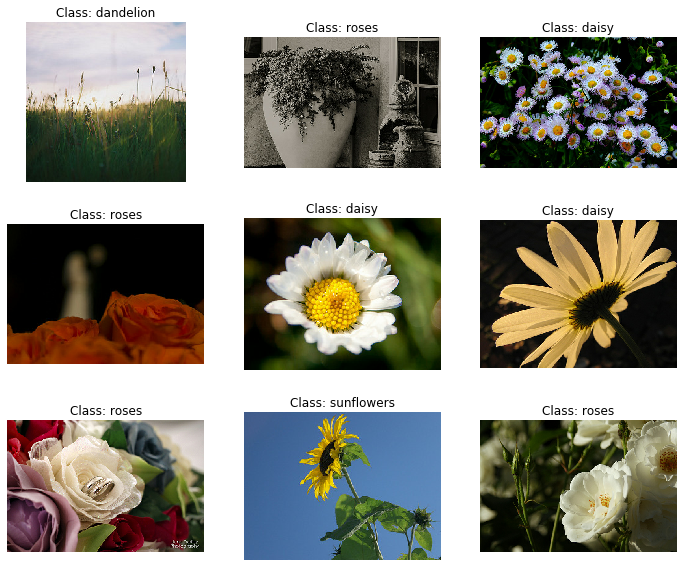

In [65]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

Basic preprocessing:

In [67]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

Slightly fancier preprocessing (but you could add much more data augmentation):

In [68]:
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

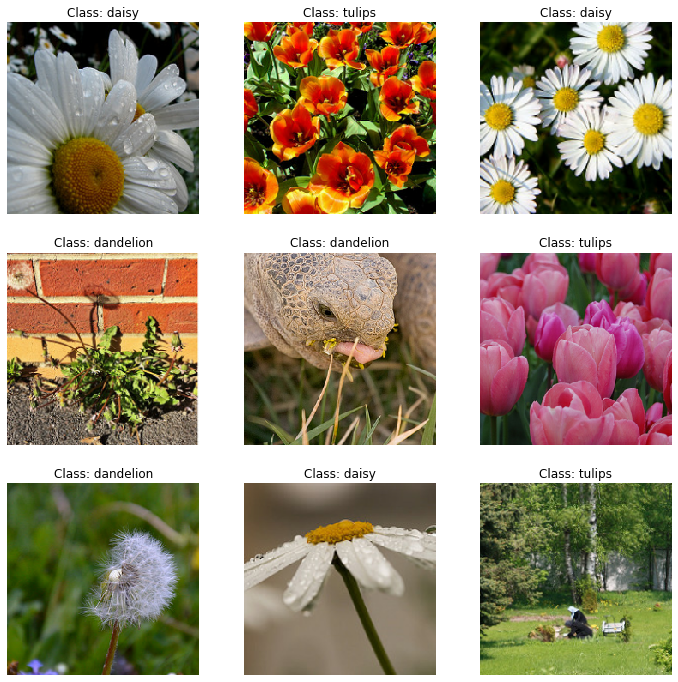

In [71]:
plt.figure(figsize=(12, 12))

for X_batch, y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

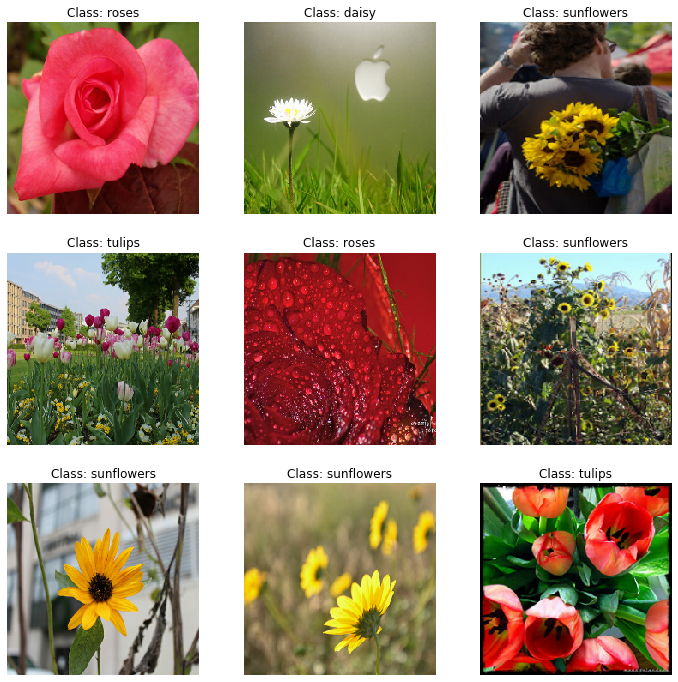

In [72]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in test_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

In [73]:
# We exclude the top of the network 
# this excludes the global average pooling layer and the dense output layer
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

83689472/83683744 [==============================] - 6s 0us/step


In [74]:
for index, layer in enumerate(base_model.layers):
    print(index, layer.name)

0 input_2
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_81
13 block2_pool
14 batch_normalization_73
15 add
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_82
23 block3_pool
24 batch_normalization_74
25 add_1
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_83
33 block4_pool
34 batch_normalization_75
35 add_2
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_3
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_se

It’s usually a good idea to freeze the weights of the pretrained layers, at least at the beginning of training:

In [75]:
for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)

Train for 86 steps, validate for 17 steps
Epoch 1/5
86/86 [==============================] - 267s 3s/step - loss: 0.7378 - accuracy: 0.7733 - val_loss: 1.5384 - val_accuracy: 0.7298
Epoch 2/5
86/86 [==============================] - 224s 3s/step - loss: 0.4080 - accuracy: 0.8750 - val_loss: 1.3501 - val_accuracy: 0.7500
Epoch 3/5
86/86 [==============================] - 221s 3s/step - loss: 0.3253 - accuracy: 0.8932 - val_loss: 1.0059 - val_accuracy: 0.8217
Epoch 4/5
86/86 [==============================] - 213s 2s/step - loss: 0.2918 - accuracy: 0.8961 - val_loss: 1.3773 - val_accuracy: 0.7371
Epoch 5/5
86/86 [==============================] - 211s 2s/step - loss: 0.2391 - accuracy: 0.9204 - val_loss: 0.9975 - val_accuracy: 0.7923


In [76]:
for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=40)

Train for 86 steps, validate for 17 steps
Epoch 1/40
86/86 [==============================] - 643s 7s/step - loss: 0.2613 - accuracy: 0.9121 - val_loss: 0.4574 - val_accuracy: 0.9007
Epoch 2/40
86/86 [==============================] - 632s 7s/step - loss: 0.1143 - accuracy: 0.9629 - val_loss: 0.3494 - val_accuracy: 0.9099
Epoch 3/40
86/86 [==============================] - 636s 7s/step - loss: 0.0582 - accuracy: 0.9804 - val_loss: 0.2954 - val_accuracy: 0.9375
Epoch 4/40
86/86 [==============================] - 628s 7s/step - loss: 0.0332 - accuracy: 0.9902 - val_loss: 0.2457 - val_accuracy: 0.9393
Epoch 5/40
86/86 [==============================] - 617s 7s/step - loss: 0.0283 - accuracy: 0.9913 - val_loss: 0.2751 - val_accuracy: 0.9301
Epoch 6/40
86/86 [==============================] - 626s 7s/step - loss: 0.0225 - accuracy: 0.9931 - val_loss: 0.2293 - val_accuracy: 0.9375
Epoch 7/40
86/86 [==============================] - 620s 7s/step - loss: 0.0161 - accuracy: 0.9945 - val_loss: 0

# Classification and Localization

In [77]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = keras.layers.Dense(n_classes, activation="softmax")(avg)
loc_output = keras.layers.Dense(4)(avg) # difference here

model = keras.models.Model(inputs=base_model.input,
                           outputs=[class_output, loc_output]) # two outputs now
model.compile(loss=["sparse_categorical_crossentropy", "mse"], # two evaluation metrics
              loss_weights=[0.8, 0.2], # depends on what you care most about
              optimizer=optimizer, metrics=["accuracy"])

In [78]:
def add_random_bounding_boxes(images, labels):
    fake_bboxes = tf.random.uniform([tf.shape(images)[0], 4])
    return images, (labels, fake_bboxes)

fake_train_set = train_set.take(5).repeat(2).map(add_random_bounding_boxes)

In [79]:
fake_train_set

<MapDataset shapes: ((None, 224, 224, 3), ((None,), (None, 4))), types: (tf.float32, (tf.int64, tf.float32))>

In [80]:
model.fit(fake_train_set, steps_per_epoch=5, epochs=2)

Train for 5 steps
Epoch 1/2
5/5 [==============================] - 43s 9s/step - loss: 1.3339 - dense_6_loss: 1.5735 - dense_7_loss: 0.3754 - dense_6_accuracy: 0.3187 - dense_7_accuracy: 0.2188
Epoch 2/2
5/5 [==============================] - 97s 19s/step - loss: 1.2686 - dense_6_loss: 1.5082 - dense_7_loss: 0.3100 - dense_6_accuracy: 0.3500 - dense_7_accuracy: 0.2375


### Mean Average Precision (mAP)

In [81]:
def maximum_precisions(precisions):
    return np.flip(np.maximum.accumulate(np.flip(precisions)))

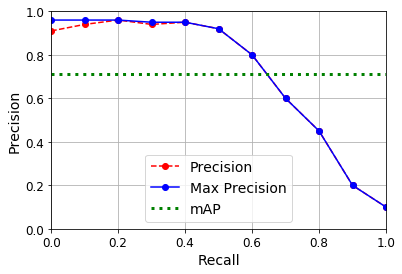

In [82]:
recalls = np.linspace(0, 1, 11)

precisions = [0.91, 0.94, 0.96, 0.94, 0.95, 0.92, 0.80, 0.60, 0.45, 0.20, 0.10]
max_precisions = maximum_precisions(precisions)
mAP = max_precisions.mean()
plt.plot(recalls, precisions, "ro--", label="Precision")
plt.plot(recalls, max_precisions, "bo-", label="Max Precision")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.plot([0, 1], [mAP, mAP], "g:", linewidth=3, label="mAP")
plt.grid(True)
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower center", fontsize=14)
plt.show()

Transpose convolutions:

In [83]:
tf.random.set_seed(42)
X = images_resized.numpy()

conv_transpose = keras.layers.Conv2DTranspose(filters=5, kernel_size=3, strides=2, padding="VALID")
output = conv_transpose(X)
output.shape

TensorShape([2, 449, 449, 5])

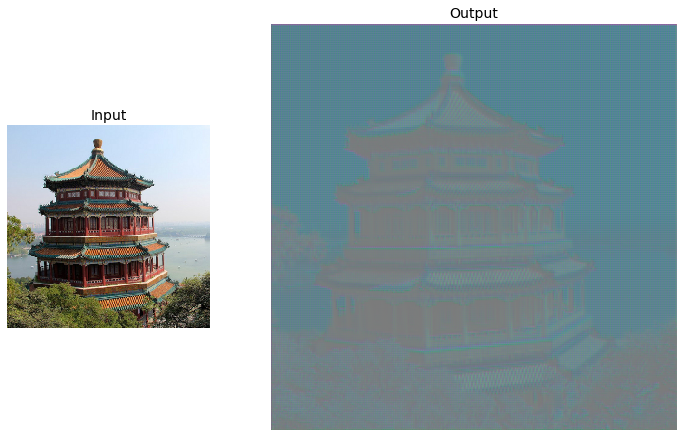

In [85]:
def normalize(X):
    return (X - tf.reduce_min(X)) / (tf.reduce_max(X) - tf.reduce_min(X))

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[1, 2])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(X[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(normalize(output[0, ..., :3]), interpolation="bicubic")  # plot the output for the 1st image
ax2.axis("off")
plt.show()

In [86]:
def upscale_images(images, stride, kernel_size):
    batch_size, height, width, channels = images.shape
    upscaled = np.zeros((batch_size,
                         (height - 1) * stride + 2 * kernel_size - 1,
                         (width - 1) * stride + 2 * kernel_size - 1,
                         channels))
    upscaled[:,
             kernel_size - 1:(height - 1) * stride + kernel_size:stride,
             kernel_size - 1:(width - 1) * stride + kernel_size:stride,
             :] = images
    return upscaled

In [87]:
upscaled = upscale_images(X, stride=2, kernel_size=3)
weights, biases = conv_transpose.weights
reversed_filters = np.flip(weights.numpy(), axis=[0, 1])
reversed_filters = np.transpose(reversed_filters, [0, 1, 3, 2])
manual_output = tf.nn.conv2d(upscaled, reversed_filters, strides=1, padding="VALID")

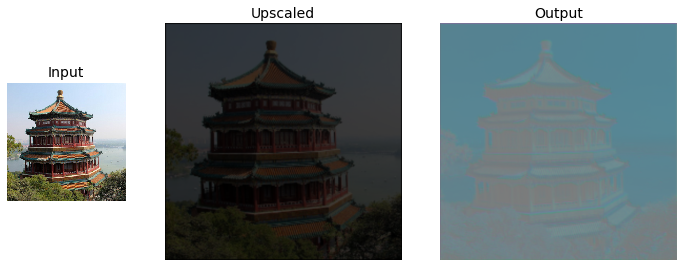

In [88]:
def normalize(X):
    return (X - tf.reduce_min(X)) / (tf.reduce_max(X) - tf.reduce_min(X))

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=3, width_ratios=[1, 2, 2])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(X[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Upscaled", fontsize=14)
ax2.imshow(upscaled[0], interpolation="bicubic")
ax2.axis("off")
ax3 = fig.add_subplot(gs[0, 2])
ax3.set_title("Output", fontsize=14)
ax3.imshow(normalize(manual_output[0, ..., :3]), interpolation="bicubic")  # plot the output for the 1st image
ax3.axis("off")
plt.show()

In [89]:
np.allclose(output, manual_output.numpy(), atol=1e-7)

True